In [1]:
import numpy as np
import matplotlib

%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

# Find contours

In [15]:
def find_contours(img):
    height, width, d = img.shape

    img = img[70:height - 70, 70:width - 70]
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #slight blur for noise removal
    imgray = cv2.GaussianBlur(imgray, (5,5), 5)
    
    #set threshold
    ret, thresh = cv2.threshold(imgray, 40, 100, 0)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = max(contours, key = cv2.contourArea)
    
    return contours
 

def find_fourier(contours):
    xs = [pt[0][0] for pt in contours]
    ys = [pt[0][1] for pt in contours]

    contour_complex = np.empty(len(xs), dtype=complex)

    #the x coordinates of the points on the contour
    contour_complex.real= xs
    # the y coordinates of the points on the contour
    contour_complex.imag= ys

    fourier_result = np.fft.fft(contour_complex)
    
    return fourier_result

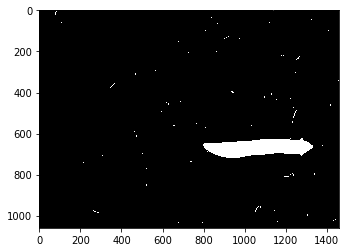

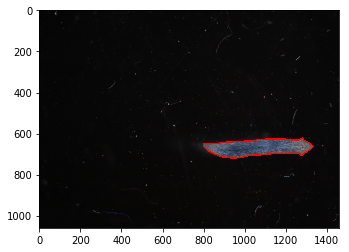

In [16]:
img = cv2.imread('../finalproj/W25-PT-D11.TIF')
height, width, d = img.shape

img = img[70:height - 70, 70:width - 70]
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(imgray, 40, 100, 0)
plt.figure(); plt.imshow(thresh,cmap="gray")

#lower = np.array([70, 90, 0])
#upper = np.array([100, 130, 100])
#thresh = cv2.inRange(img, lower, upper)
#plt.figure(); plt.imshow(thresh,cmap="gray")

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

contours = max(contours, key = cv2.contourArea)
drawn = cv2.drawContours(img, contours, contourIdx = -1, color = (255,0,0), thickness = 5)
plt.figure(); plt.imshow(drawn,cmap="gray")

The contour is actually just a long list of points, ordered in a way that traces the outline of the cat.

The next step is to separate the x and y coordinates of these points

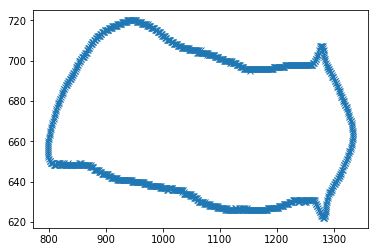

In [17]:
xs = [pt[0][0] for pt in contours]
ys = [pt[0][1] for pt in contours]

contour_complex = np.empty(len(xs), dtype=complex)

#the x coordinates of the points on the contour
contour_complex.real= xs
# the y coordinates of the points on the contour
contour_complex.imag= ys

plt.plot(contour_complex.real,contour_complex.imag,'x-')

Next up we run the Fast Fourier Tranform on the points

In [18]:
fourier_result = np.fft.fft(contour_complex)

We can plot what the fourier frequencies look like here

546


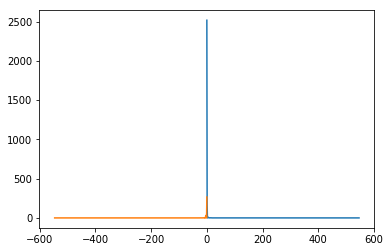

In [19]:
N = len(contour_complex)
T = 1/N
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
xf2 = np.linspace(0.0, -1.0/(2.0*T), (N//2))

if (N%2 == 0):
    backhalf = fourier_result[(N//2):]
else:
    backhalf = fourier_result[(N//2)+1:]

backhalf = backhalf[::-1]
print(len(backhalf))
plt.plot(xf, 2.0/N * np.abs(fourier_result[0:N//2]))
plt.plot(xf2, 2.0/N * np.abs(backhalf))
plt.show()

# Modify contour

## Center the contour 
Setting the 0th coefficient to 0.

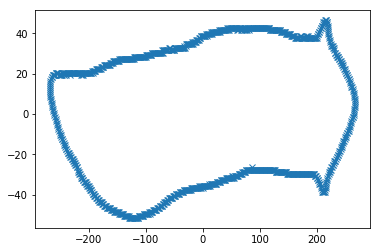

In [20]:
fourier_result[0] = 0
new_contour = np.fft.ifft(fourier_result)
plt.plot(new_contour.real,-1*new_contour.imag,'x-')
plt.show()

We can see what happens when we perform a low-pass filter by zeroing out the coefficients above a certain frequency.

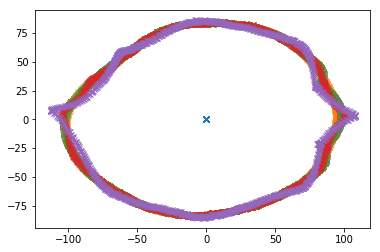

In [21]:
for cutoff in range(0,N//2,10):
    fourier_result2 = fourier_result.copy()
    fourier_result2[cutoff:N//2] = 0+0j
    fourier_result2[(N//2)+cutoff:] = 0+0j
    new_contour2 = np.fft.ifft(fourier_result2)
    plt.plot(new_contour2.real,-1*new_contour2.imag,'x-')
    
plt.show() 

## Normalize contour

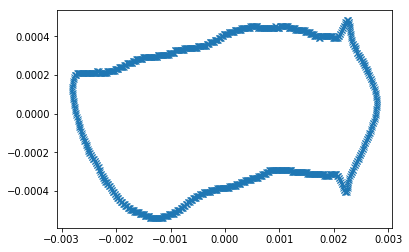

In [23]:
def fourier_normalize(fourier):
    #set the DC component of the descriptors to 0
    fourier[0] = 0
    
    #divide all the Fourier descriptors with the magnitude of the second one
    fourier = fourier/abs(fourier[1])
    
    return fourier

img = cv2.imread('../finalproj/W25-PT-D11.TIF')
contour = find_contours(img)
fourier = find_fourier(contour)
normalize = fourier_normalize(fourier)

new_contour = np.fft.ifft(normalize)
plt.plot(new_contour.real,-1*new_contour.imag,'x-')
plt.show()

# Compare contours

cv2.matchShapes() enables comparison between two shapes, or two contours and returns a metric showing the similarity.
The lower the result, the better the match is. 

In [25]:
img1 = cv2.imread('../finalproj/W25-PT-D11.TIF')
img2 = cv2.imread('../finalproj/W5-PT-D11.TIF')
img3 = cv2.imread('../finalproj/W16-PT-D11.TIF')

contour1 = find_contours(img1)
contour2 = find_contours(img2)
contour3 = find_contours(img3)

fourier1 = find_fourier(contour1)
fourier2 = find_fourier(contour2)
fourier3 = find_fourier(contour3)

normalize1 = fourier_normalize(fourier1)
normalize2 = fourier_normalize(fourier2)
normalize3 = fourier_normalize(fourier3)

c1 = [[x, y] for x in normalize1.real for y in -1*normalize1.imag]
c2 = [[x, y] for x in normalize2.real for y in -1*normalize2.imag]
c2 = [[x, y] for x in normalize3.real for y in -1*normalize3.imag]

compare = cv2.matchShapes(contour1,contour2, 1, 0.0)
print(compare)

compare2 = cv2.matchShapes(contour1,contour3, 1, 0.0)
print(compare2)

2.5121193334729015
6.198425874424
